In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import random
from spike_generator import *
plt.style.use('dark_background')
#plt.style.use('seaborn-whitegrid');
%matplotlib inline

## Task 6. White-noise stimulus
Build an approximate white-noise stimulus by choosing random values at discrete times separated by time interval $\Delta t$. Plot its **autocorrelation** function and **power spectrum**. Discuss how well this stimulus matches an ideal white-noise stimulus given the value of $\Delta t$ you used.

Let's assume that whatever stimulus we had, we normalized it to be in range the $[0, 1]$:

In [2]:
Δt = 1e-2
time = np.arange(0, 10, Δt)
stimulus = np.random.uniform(0, 10, *np.shape(time)) 

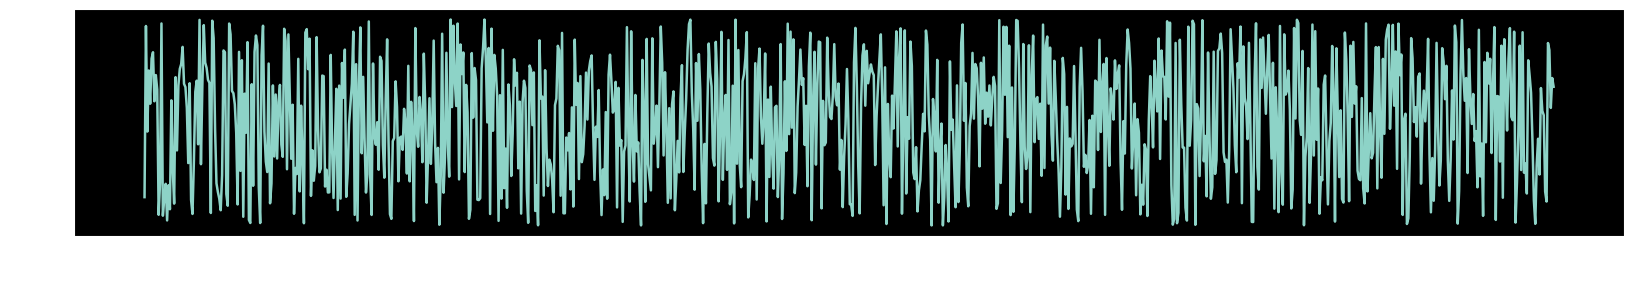

In [3]:
plt.figure(figsize=(20, 3), dpi=100);
plt.plot(time, stimulus, lw=1.8);
plt.xlabel('time [s]', fontsize=17);
plt.ylabel('s(t)', rotation=0, fontsize=17, labelpad=12);

### Power spectrum
First, let's plot just spectral density

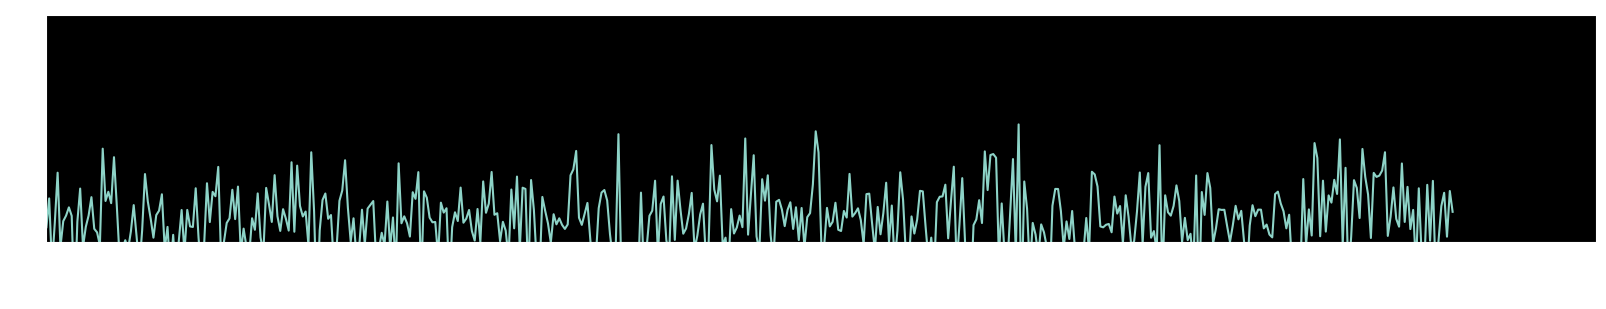

In [4]:
spectrum = np.fft.fft(stimulus)
freqs = np.fft.fftfreq(time.size, Δt)
plt.figure(figsize=(20, 3), dpi=100);
plt.plot(sorted(freqs), spectrum.real);
plt.xlim(0, 55);
plt.ylim(-50, 400);
plt.xlabel('Frequency, Hz', fontsize=20);
rc('xtick', labelsize=20);

Our spectrum ends at 50 Hz due to the limitation of our Δt, the maximum possible frequency is $1/(2 \cdot \Delta t) = 50 Hz$ (it is similar to the resolution of some measuring instrument)

And now the actual **power spectrum**

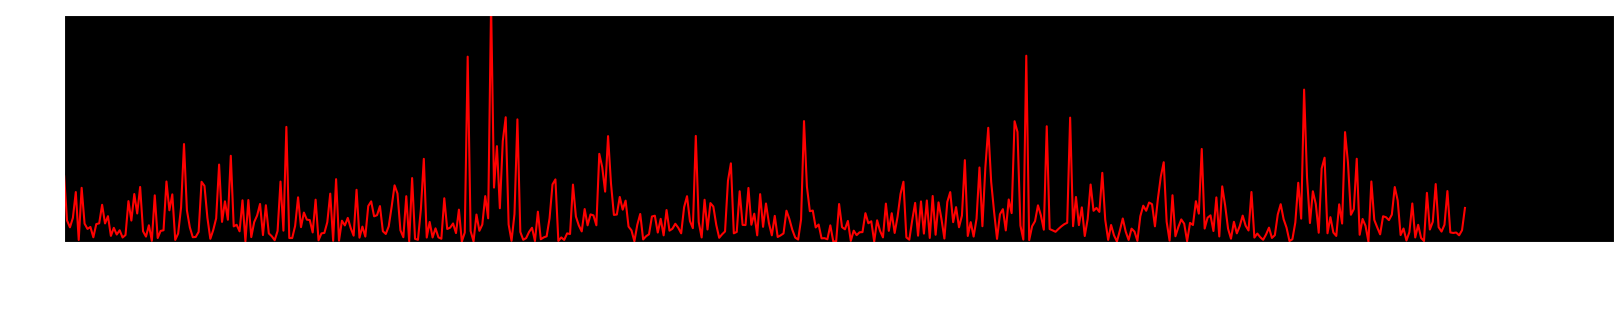

In [5]:
power_spectrum = np.abs(spectrum)**2
plt.figure(figsize=(20, 3), dpi=100);
plt.plot(sorted(freqs), power_spectrum, lw=1.5, color='red');
plt.xlim(2, 55);
plt.ylim(0, 7e4);
plt.xlabel('Frequency, Hz', fontsize=20);
rc('xtick', labelsize=20);

### Autocorrelation
Finally, **autocorrelation** of white-noise stimulus. But, for better approximatin, let's generate white noise for a longer period of time

Text(0.5, 1.0, 'Autocorrelation histogram for white noise')

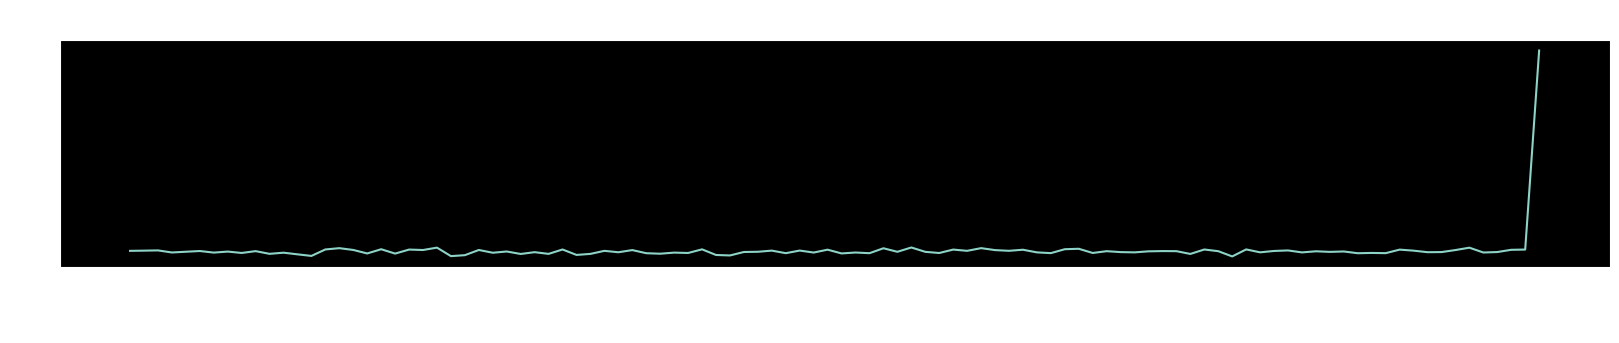

In [6]:
Δt = 1e-3

time_longer = np.arange(0, 10, Δt)
stimulus_longer = np.random.uniform(0, 10, *np.shape(time_longer))
Q_ss, t_Q_ss = crosscorrelation2(stimulus_longer, stimulus_longer, time_longer, time_lag=100)
plt.figure(figsize=(20, 3), dpi=100);
plt.plot(t_Q_ss, Q_ss)
plt.xlabel('Time lag, ms', fontsize=17)
plt.title('Autocorrelation histogram for white noise', fontsize=20)
#plt.ylim(0, 8)

From all the above plots it is evident that our white-noise approximation is pretty good: we don't have any significant differences in amplitudes for our frequencies nor have noticeable autocorrelation for any given time lag.

Let's also try to generate white-noise from a normal dustribution

In [7]:
σ = 1 # reflects the magnitude of the variability of the white-noise
stimulus2 = np.random.normal(0, σ**2/Δt, time.size)
freqs = np.fft.fftfreq(time.size, Δt)

Text(0.5, 1.0, 'Gaussian white-noise')

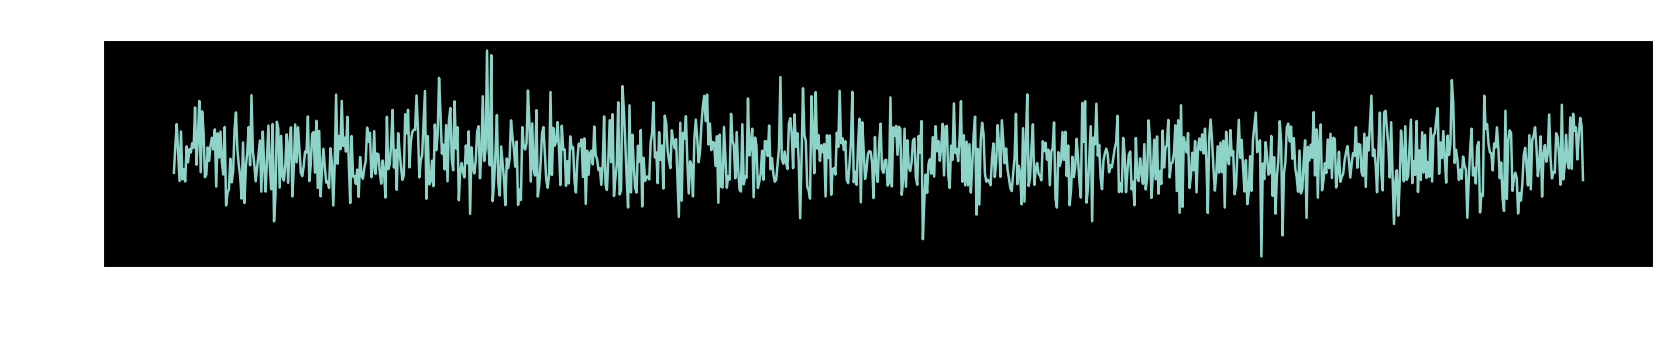

In [8]:
plt.figure(figsize=(20, 3), dpi=100);
plt.plot(time, stimulus2, lw=1.8);
plt.xlabel('time [s]', fontsize=17);
plt.ylabel('s(t)', rotation=0, fontsize=17, labelpad=12);
plt.title('Gaussian white-noise', fontsize=20)

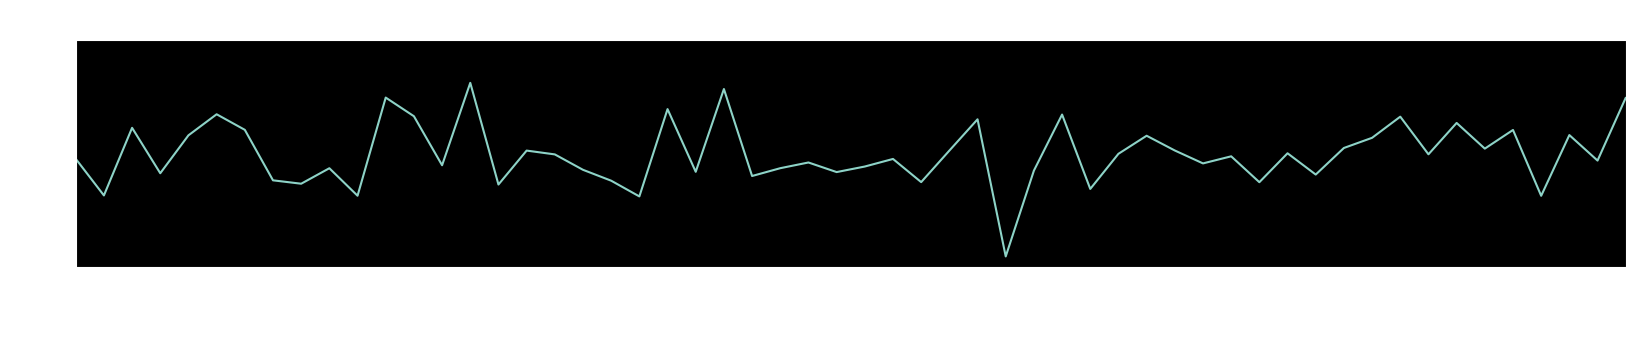

In [9]:
spectrum2 = np.fft.fft(stimulus2)
plt.figure(figsize=(20, 3), dpi=100);
plt.plot(sorted(freqs), spectrum2.real);
plt.xlim(0, 55);
#plt.ylim(-50, 400);
plt.xlabel('Frequency, Hz', fontsize=20);
plt.title('Gaussian white-noise spectral density', fontsize=20)
rc('xtick', labelsize=20);

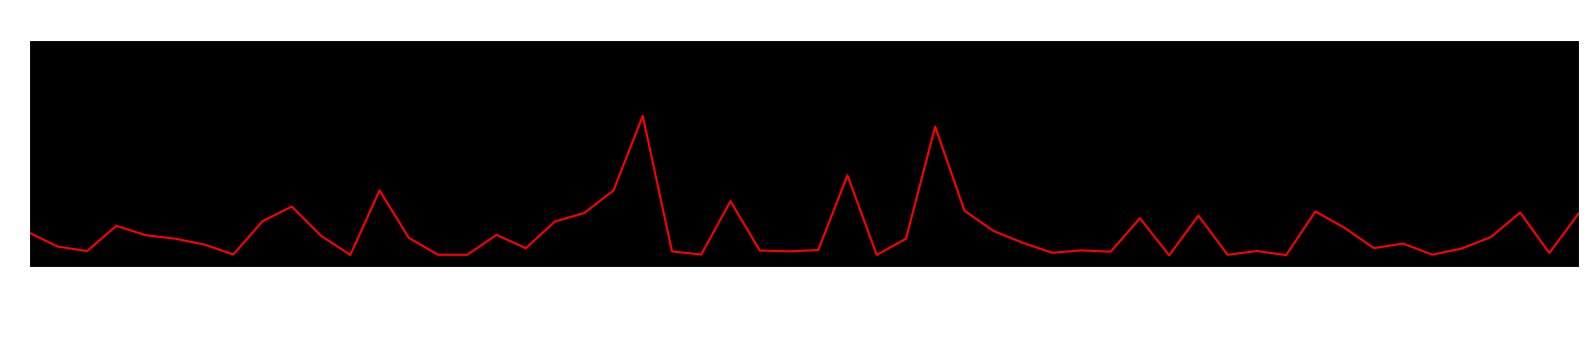

In [10]:
power_spectrum2 = np.abs(spectrum2)**2
plt.figure(figsize=(20, 3), dpi=100);
plt.plot(sorted(freqs), power_spectrum2, lw=1.5, color='red');
plt.xlim(2, 55);
plt.xlabel('Frequency, Hz', fontsize=20);
plt.title('Gaussian white-noise power spectrum', fontsize=20)
rc('xtick', labelsize=20);

## Task 7. Firing rate driven by white-noise
Consider a model with a firing determined in terms of a stimulus $s(t)$ by integrating the equation:

$$
\tau_r \frac{dr_{est}(t)}{dt} = [r_0 + s(t)]_+ - r_{est}(t)
$$

where $r_0$ determines background firing rate and $\tau_r = 20 \ ms$. Drive the model with an approximate white-noise stimulus. Adjust the
amplitude of the white-noise and the parameter $r_0$ so that rectification is not a big effect (i.e. $r_0 + s > 0$ most of the time). From the responses of the model, compute the stimulus-response
correlation function $Q_{rs}$. Next, generate spikes from this model
using a Poisson generator with a rate $r_{est}(t)$, and compute
the spike-triggered average stimulus from the spike trains produced
by the white-noise stimulus. By comparing the stimulus-response correlation function with the spike-triggered average, verify that equation 1.22 is satisfied. 
Examine what happens if you set $r_0=0$, so that the white-noise stimulus becomes half-wave rectified. 


The correlation between stimulus and response can be expressed
as follows (eq. 1.21):

$$
Q_{rs}(\tau) = \frac{1}{T} \int_{0}^T{dt \ r(t)  s(t + \tau)}
$$

The spike-triggered average stimulus (eq. 1.20):

$$
C(\tau) = \frac{1}{\langle n \rangle } \int_{0}^T{dt \
\langle \rho(t) \rangle  s(t - \tau)} = \frac{1}{\langle n \rangle } \int_{0}^T{dt \ r(t) s(t - \tau)}
$$

And from here we can derive eq. 1.22:

$$
Q_{rs}(-\tau) = \frac{1}{T} \int_{0}^T{dt \ r(t) \ s(t - \tau)}
$$

$$
C(\tau) = \frac{T}{\langle n \rangle} Q_{rs}(-\tau) = 
\frac{1}{\langle r \rangle} Q_{rs}(-\tau)
$$


In [31]:
from scipy.integrate import solve_ivp # means solve initial value problem

np.random.seed(5321)
Δt = 1e-3
def s(t):
    '''White noise input to diff. eq.
    '''
    s_val = np.random.normal(0, 0.03/Δt)
    return s_val 

def diff_r_est(t, r):
    '''Write our differential equation as a function for solve_ivp
    '''
    r_0 = 10 # Hz
    τ_r = 20  # ms
    new_val = r_0 + s(t)
    if new_val > 0:
        drdt = 1000*(new_val - r)/τ_r
    else:
        drdt = -r/τ_r
    return drdt

# Define time spans, initial values, and constants
tspan = np.arange(0, 10, Δt)
r_init = [10]

# Solve differential equation
sol = solve_ivp(diff_r_est, [tspan[0], tspan[-1]], r_init, t_eval=tspan)

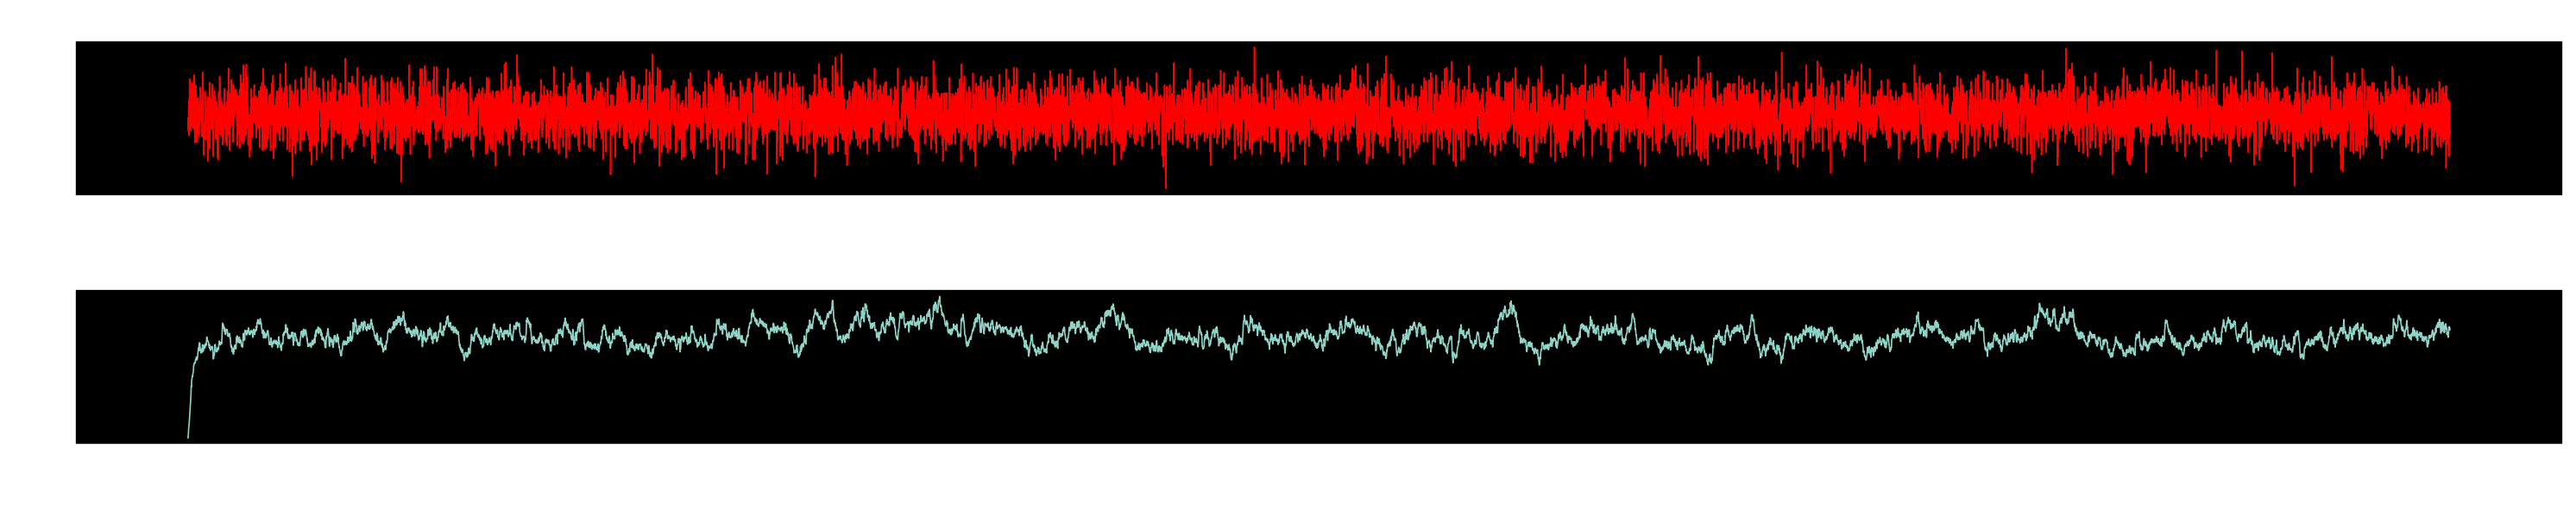

In [32]:
np.random.seed(5321)
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(20, 4))
ax[0].plot(sol.t, np.array([s(t) for t in sol.t]), 'r-', lw=0.8)
ax[0].set_title('White-noise input')
ax[1].plot(sol.t, sol.y[0], lw=0.8)
ax[1].set_title('Firing rate driven by white-noise')
plt.tight_layout()

In [33]:
np.random.seed(5321)
wn_stim = np.array([s(t) for t in sol.t])
rate = sol.y[0]
time = sol.t
Q, t = crosscorrelation2(rate, wn_stim, time, time_lag=150)

In [44]:
rs_corr = np.correlate(rate, wn_stim, 'full') * (Δt/len(wn_stim))

In [45]:
Δt * 150 *1000

150.0

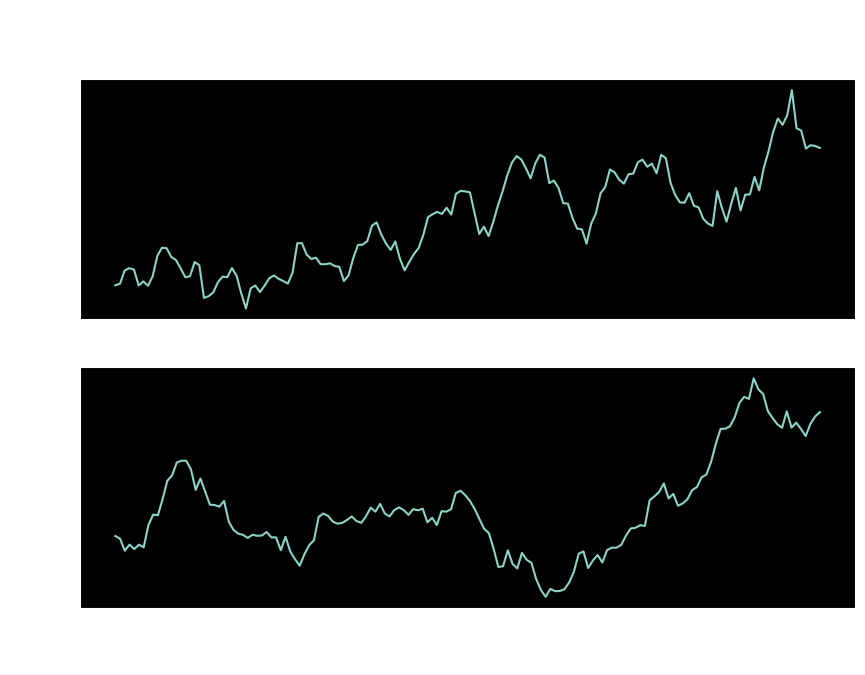

In [50]:
fig, axs = plt.subplots(2, 1, dpi=100, figsize=(10, 7));
axs[0].plot(t*1000, Q);
axs[1].plot(np.arange(0, 150, 1), rs_corr[9850:10000])
axs[1].set_xlabel('Time lag, ms');
fig.suptitle('Response-stimulus cross correlation function');

Let's generate spikes from this model

In [78]:
spikes, start_spikes = NonhomogeneousPoissonVector(rate, time, 10)

[Text(0.5, 0, 'time [s]')]

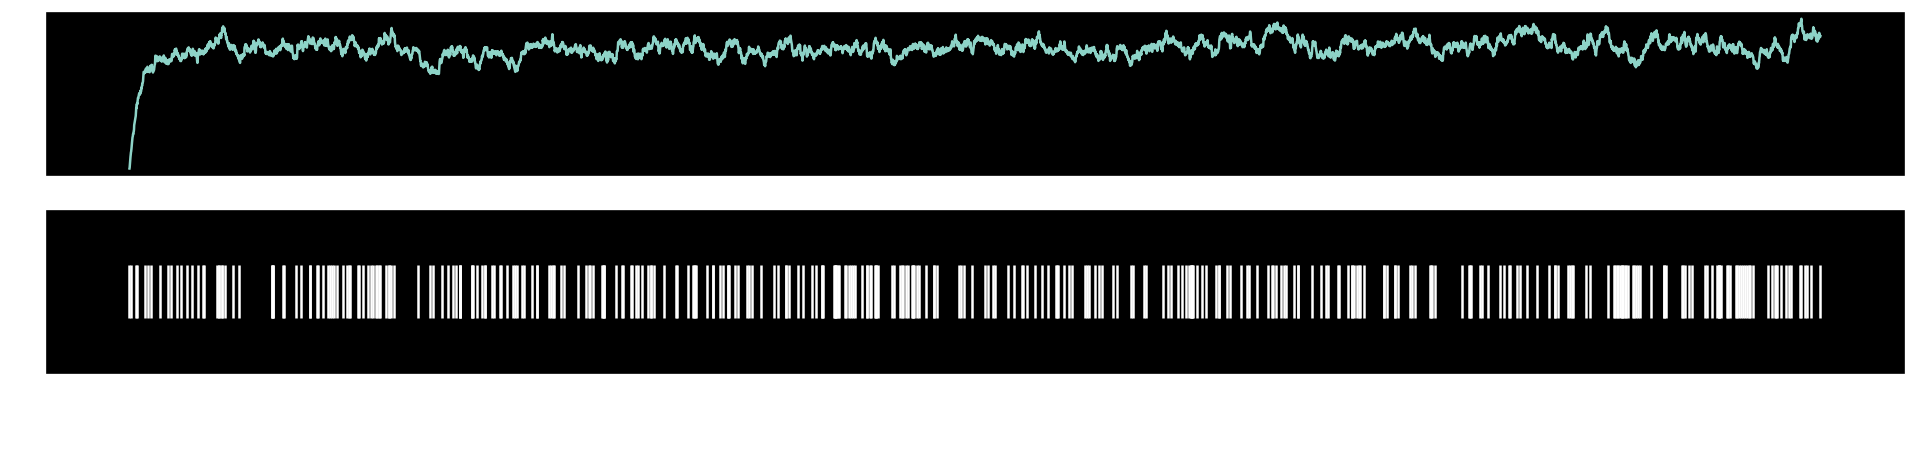

In [79]:
fig, axs = plt.subplots(2, 1, figsize=(20, 4), dpi=120)
axs[0].plot(time, rate)
axs[1].eventplot(spikes, linelength=0.7)
axs[1].set(xlabel='time [s]')

Calculate spike-triggered average 

In [80]:
print(spikes.max())
spike_binary = np.zeros(time.shape)
for i in spikes:
    spike_binary[int((i/time.max()) * len(time))] = 1

10.027606172113343


IndexError: index 10028 is out of bounds for axis 0 with size 10000

In [51]:
spike_binary = np.array(spike_binary)
print(np.shape(spike_binary), np.shape(wn_stim))
print(len(spike_binary[spike_binary==1]),len(spikes))

(10000,) (10000,)
584 596


In [52]:
wn_stim = np.reshape(wn_stim, (np.shape(wn_stim)[0], 1))
print(wn_stim.shape)

(10000, 1)


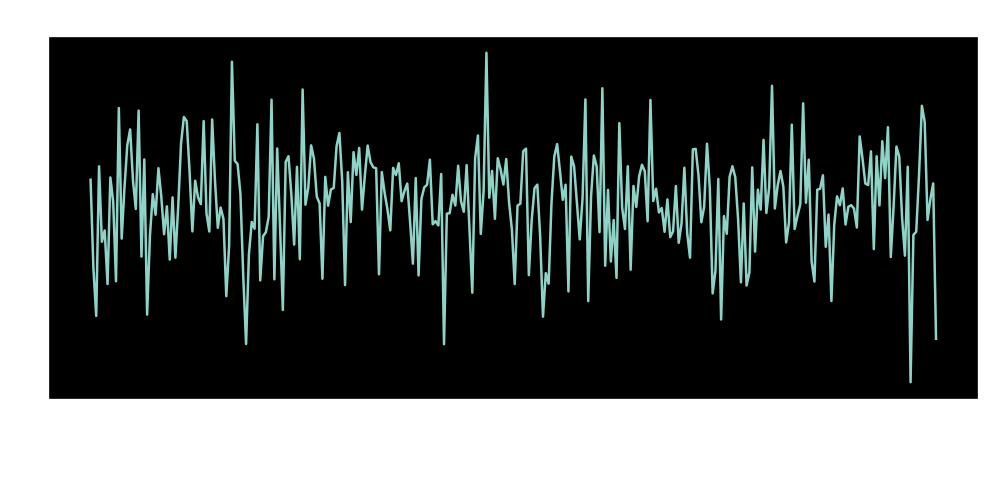

In [53]:
avg_stim, t_stim = STA_new(wn_stim, time, spike_binary, window=300)
fig, axs = plt.subplots(1, 1, dpi=120, figsize=(10, 4));
axs.plot(t_stim*1000, avg_stim);
axs.set(xlabel='time [ms]')
axs.set_title('Spike-triggered average for the white noise stimulus');

Need to improve function for computing cross-correlation, because it can't be used for negative τ's yet.